In [131]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
import open3d as o3d
from PIL import Image

In [139]:
obj_path = "../no_git_test_data/88-1/model_cleaned.obj"

tm_test = trimesh.load(obj_path)
# meshes = pyrender.Mesh.from_trimesh(tm_test)
# scene = pyrender.Scene()
# scene.add(meshes)

# # camera = pyrender.PerspectiveCamera(yfov=np.pi/3, aspectRatio=1)
# pyrender.Viewer(scene)

# dir = *(...row1), *(...row2), ... 
grid = (np.indices((512, 512)).swapaxes(0, 2).reshape((-1, 2)) - 256) 
directions = np.concatenate([grid / 256 / np.sqrt(3), np.ones((grid.shape[0], 1))*-1], axis=1)
origins = np.zeros(directions.shape)
origins[:, -1] = 1

result = tm_test.ray.intersects_id(origins, directions, multiple_hits=True, max_hits=4, return_locations=True)

In [ ]:
pcd = o3d.geometry.PointCloud()
ref_pcd = directions
pcd.points = o3d.utility.Vector3dVector()
o3d.io.write_point_cloud(f"../no_git_test_data/pcd/ref.ply", pcd)

In [150]:
result[1]

array([131328, 131328, 141568, ..., 112406, 167674, 114471], dtype=int64)

In [146]:
import pandas as pd

_, peelmap_idx, locations = result
argsort = np.argsort(locations[:, -1])[::-1]
locations = locations[argsort]
peelmap_idx = peelmap_idx[argsort]

counts = pd.Series(peelmap_idx)
counts = counts.groupby(counts).cumcount().to_numpy()

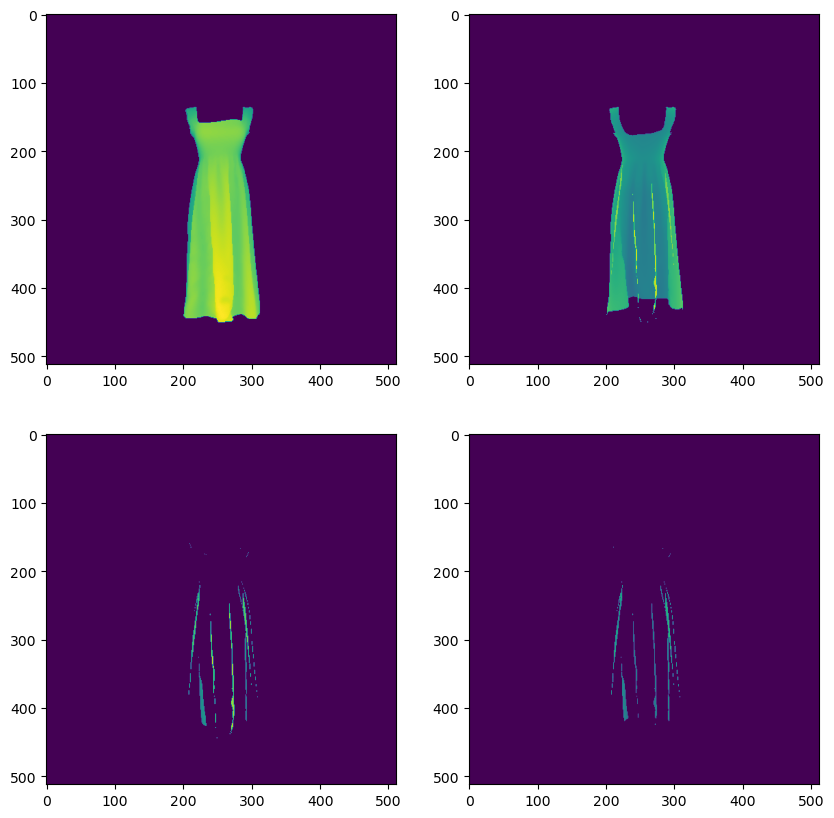

In [147]:
# i = layer; peelmaps[i] = (world_coords, pixel_coords)
peelmaps = [(locations[counts == i], peelmap_idx[counts == i]) for i in range(4)]
pm_depth = []

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, (world_coords, pixel_coords) in enumerate(peelmaps):
    row = pixel_coords // 512
    col = pixel_coords % 512

    # compute depth
    depth = np.zeros((512, 512))
    depth[row, col] = world_coords[:, -1]
    pm_depth.append(depth)
    
    # save depth info
    with open(f"../no_git_test_data/pcd/peelmap_depth_{i}.npy", "wb") as f:
        np.save(f, depth)

    # for display, rescale the depth between 0.3 - 0.8
    tmp = depth[row, col]
    tmp = np.interp(tmp, (tmp.min(), tmp.max()), (0.3, 0.8))
    depth_img = np.zeros_like(depth)
    depth_img[row, col] = tmp
    ax[i//2, i%2].imshow(depth_img[::-1, ::-1])
    
    # save pcd
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(world_coords)
    o3d.io.write_point_cloud(f"../no_git_test_data/pcd/peelmap_{i}.ply", pcd)

array([-0.08671488, -0.0850114 , -0.08359063, ..., -0.06742915,
       -0.06680074, -0.0661569 ])

In [157]:
col

array([-256, -256, -256, ...,  255,  255,  255])

In [159]:
# reconstruct from depth
pcd = []
row, col = grid[:, 0], grid[:, 1]
for depth in pm_depth:
    f_d = depth[row, col].reshape(-1, 1)
    p = grid / 256 / np.sqrt(3) * np.abs(f_d)
    p = np.hstack([p, f_d])
    pcd.append(p)    
    break

pcd = np.vstack(pcd)
reconstructed = o3d.geometry.PointCloud()
reconstructed.points = o3d.utility.Vector3dVector(pcd)
o3d.io.write_point_cloud(f"../no_git_test_data/pcd/reconstructed.ply", reconstructed)

True

In [149]:
# import open3d as o3d

# eagle = o3d.data.EaglePointCloud()
# pcd = o3d.io.read_point_cloud(eagle.path)

# o3d.visualization.draw_geometries([pcd],
#                                   zoom=0.664,
#                                   front=[-0.4761, -0.4698, -0.7434],
#                                   lookat=[1.8900, 3.2596, 0.9284],
#                                   up=[0.2304, -0.8825, 0.4101])


# print('run Poisson surface reconstruction')
# with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
#     mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)
# print(mesh)
# o3d.visualization.draw_geometries([mesh],
#                                   zoom=0.664,
#                                   front=[-0.4761, -0.4698, -0.7434],
#                                   lookat=[1.8900, 3.2596, 0.9284],
#                                   up=[0.2304, -0.8825, 0.4101])